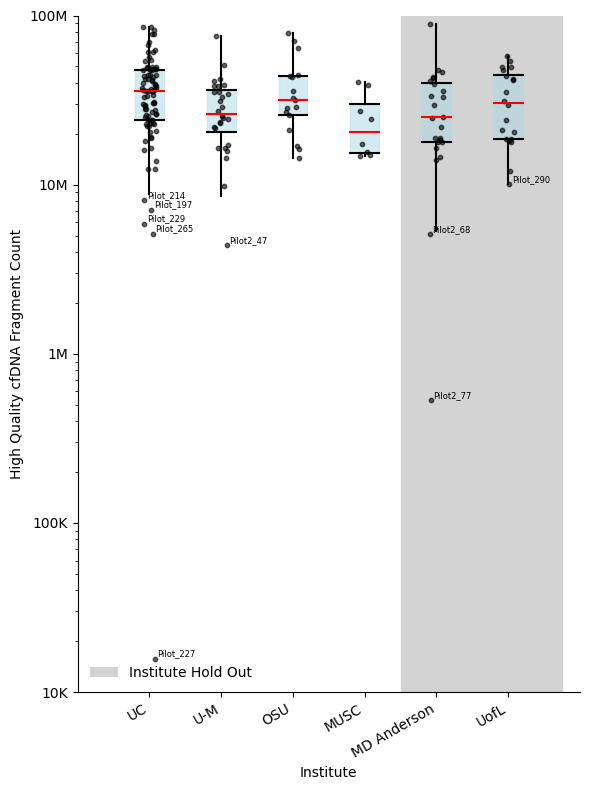

In [6]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

institute_label_map = {
    "University of Cincinnati": "UC",
    "University of Michigan": "U-M",
    "MD Anderson": "MD Anderson",
    "University of Louisville": "UofL",
    "Ohio State University": "OSU",
    "Medical University of South Carolina": "MUSC"
}

fragment_counts = pd.read_csv('../../Supplementary_Tables/ST2/cfDNA_quality_metrics.tsv', sep='\t', header=None, skiprows=1, usecols=[0,5] )
metadata = pd.read_csv('../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv')
metadata['ID'] = metadata['ID'].str.replace('-', '_', regex=False)

merged_df = pd.merge(fragment_counts, metadata, left_on=fragment_counts.columns[0], right_on='ID')
merged_df = merged_df.drop(columns=fragment_counts.columns[0])
merged_df = merged_df.rename(columns={fragment_counts.columns[1]: 'Fragment Count'})
merged_df = merged_df[["Fragment Count", "ID", "Institute"]]
merged_df['Fragment Count'] = merged_df['Fragment Count'] / 1e6

institute_counts = merged_df['Institute'].value_counts().reset_index()
institute_counts.columns = ['Institute', 'Count']
holdout_institutes = ["MD Anderson", "University of Louisville"]
other_institutes = [i for i in institute_counts['Institute'] if i not in holdout_institutes]
ordered_institutes = other_institutes + holdout_institutes

def boxplot_stats_log(data):
    data_log = np.log10(data[data > 0])
    Q1_log = data_log.quantile(0.25)
    Q3_log = data_log.quantile(0.75)
    IQR_log = Q3_log - Q1_log
    lower_whisker_log = max(data_log.min(), Q1_log - 1.5 * IQR_log)
    upper_whisker_log = min(data_log.max(), Q3_log + 1.5 * IQR_log)
    return Q1_log, Q3_log, lower_whisker_log, upper_whisker_log, data_log.median()

plt.figure(figsize=(6, 8))

for i, institute in enumerate(ordered_institutes):
    subset = merged_df[merged_df['Institute'] == institute]
    data = subset['Fragment Count']
    ids = subset['ID']

    Q1_log, Q3_log, lower_whisker_log, upper_whisker_log, median_log = boxplot_stats_log(data)
    Q1 = 10**Q1_log
    Q3 = 10**Q3_log
    lower_whisker = 10**lower_whisker_log
    upper_whisker = 10**upper_whisker_log
    median = 10**median_log

    plt.plot([i + 1, i + 1], [lower_whisker, Q1], color='black')
    plt.plot([i + 1, i + 1], [Q3, upper_whisker], color='black')
    plt.plot([i + 0.8, i + 1.2], [Q1, Q1], color='black')
    plt.plot([i + 0.8, i + 1.2], [Q3, Q3], color='black')
    plt.fill_between([i + 0.8, i + 1.2], Q1, Q3, color='lightblue', alpha=0.5)
    plt.plot([i + 0.8, i + 1.2], [median, median], color='red')

    jitter = np.random.uniform(-0.1, 0.1, size=len(data))
    plt.scatter(i + 1 + jitter, data, s=10, color='black', alpha=0.6)

    for x, y, label in zip(i + 1 + jitter, data, ids):
        if y < lower_whisker and label not in [""]:
            plt.text(x + 0.3, y, label, fontsize=6, ha='center', va='bottom')
        elif y < lower_whisker:
            plt.text(x - 0.3, y, label, fontsize=6, ha='center', va='bottom')

plt.yscale('log')
def human_fmt(x, pos):
    count = x * 1e6
    if count >= 1e6:
        return f'{count/1e6:.0f}M'
    elif count >= 1e3:
        return f'{count/1e3:.0f}K'
    else:
        return f'{count:.0f}'
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(human_fmt))

plt.xlabel('Institute')
plt.ylabel('High Quality cfDNA Fragment Count')
mapped_labels = [institute_label_map.get(inst, inst) for inst in ordered_institutes]
plt.xticks(ticks=range(1, len(ordered_institutes) + 1), labels=mapped_labels, rotation=30, ha='right')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0.01,100)
plt.xlim(0,7)

plt.tight_layout()
plt.savefig('SF1B.pdf', dpi=1000, bbox_inches='tight')
plt.show()


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

metadata = pd.read_csv('../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv')

labels_to_drop = ["Pilot_214", "Pilot_197", "Pilot_229", "Pilot_265", "Pilot2_47", "Pilot2_68", "Pilot2_77", "Pilot_290", "Pilot_227"]
train_institutes = ["University of Cincinnati", "Ohio State University", "Medical University of South Carolina", "University of Michigan"]
test_institutes = ["University of Louisville", "MD Anderson"]

filtered_df = metadata[(metadata['Physician Hold-Out'] == 0) & (~metadata['ID'].isin(labels_to_drop))]

filtered_df_train = metadata[
    (metadata['Physician Hold-Out'] == 0) & 
    (~metadata['ID'].isin(labels_to_drop)) & 
    (~metadata['Institute'].isin(test_institutes))
]

filtered_df_test = metadata[
    (metadata['Physician Hold-Out'] == 0) & 
    (~metadata['ID'].isin(labels_to_drop)) & 
    (~metadata['Institute'].isin(train_institutes))
]

filtered_df_holdout = metadata[
    (metadata['Physician Hold-Out'] == 1) & 
    (~metadata['ID'].isin(labels_to_drop))
]

In [8]:
filtered_df['ID'].to_csv('../../Utils/Lists/cv_ids.txt', index=False, header=False)
filtered_df_holdout['ID'].to_csv('../../Utils/Lists/holdout_ids.txt', index=False, header=False)

In [9]:
sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler
METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = "../../Utils/Lists/holdout_ids.txt"
hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
m = hc_data.metadata

In [13]:
patient_counts = m['Patient Number'].value_counts()
patients_to_keep = patient_counts[patient_counts == 3].index
filtered_m = m[m['Patient Number'].isin(patients_to_keep)]
screen = list(filtered_m[filtered_m['Type of Visit']=="Screen"][["Type of Visit"]].to_dict()["Type of Visit"].keys())
day0 = list(filtered_m[filtered_m['Type of Visit']=="Day 0"][["Type of Visit"]].to_dict()["Type of Visit"].keys())
adjwk1 = list(filtered_m[filtered_m['Type of Visit']=="Adj Wk 1"][["Type of Visit"]].to_dict()["Type of Visit"].keys())

def write_list_to_file(my_list, file_name):
    with open(file_name, 'w') as file:
        for item in my_list:
            file.write(f"{item}\n")
            
write_list_to_file(screen, '../../Utils/Lists/screen_grouped.txt')
write_list_to_file(day0, '../../Utils/Lists/day0_grouped.txt')
write_list_to_file(adjwk1, '../../Utils/Lists/adjwk1_grouped.txt')